In [1]:
### Loading the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

#Getting Stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stopEs = stopwords.words('spanish')

#Importing K folds
from sklearn import model_selection

#Loading latent analysis Models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

#loading regression Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score,average_precision_score

# increase the width of the pandas dataframe to allow scrolling through all columns
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


In [2]:
##Defining Model Functions

def LDA(NComponents,dataSource):
    model = LatentDirichletAllocation(n_components = NComponents) ##Try different n's for robustness
    model.fit(dataSource.values)
    out = model.transform(dataSource.values)
    components = model.components_
    print ("Transformed Size: ", out.shape)
    print ("Component Size: ", components.shape)

    return out,components



In [3]:
##Choosing the Nth topic and analyzing the top chosen percentile

def topicDescription(dataSource,components,topic,percentile):
    topicData = components.iloc[topic,:] 
    indices = np.where(topicData > np.percentile(topicData, percentile))
    
    topTopic = pd.DataFrame({'Feature': dataSource.columns.values[indices],('Distribution of Topic #'+str(topic+1)): topicData.iloc[indices]}) #if from csv file
    topTopic.sort_values(('Distribution of Topic #'+str(topic+1)), inplace=True, ascending=False)
    topTopic.head(n=80)
    return topTopic

##Choosing the users that most belog to each topic
def videoDescription(dataSource,transformed,topic,percentile):
    videoData = transformed[topic]  
    dummyData = dataSource.copy()
    dummyData.insert(0, ("Weight of topic #"+ str(topic+1)), videoData)
    dummyData.sort_values(("Weight of topic #"+ str(topic+1)), inplace=True, ascending=False)

    return dummyData

In [4]:
##Adding Categories To Countries (chaning ID numbers to actual names)

#print(data['category_id'].unique()) ##find unique value of categories

def assignCategories(data):
    data['category_id'].replace(1,'Film and Animation',inplace=True)
    data['category_id'].replace(2,'Vehicles',inplace=True)
    data['category_id'].replace(10,'Music',inplace=True)
    data['category_id'].replace(15,'Pets and Animals',inplace=True)
    data['category_id'].replace(17,'Sports',inplace=True)
    data['category_id'].replace(18,'Short Movies',inplace=True)
    data['category_id'].replace(19,'Travel and Events',inplace=True)
    data['category_id'].replace(20,'Gaming',inplace=True)
    data['category_id'].replace(22,'Peaple and Blogs',inplace=True)
    data['category_id'].replace(23,'Comedy',inplace=True)
    data['category_id'].replace(24,'Entertainment',inplace=True)
    data['category_id'].replace(25,'News and Politics',inplace=True)
    data['category_id'].replace(26,'Style',inplace=True)
    data['category_id'].replace(27,'Education',inplace=True)
    data['category_id'].replace(28,'Science and Tech.',inplace=True)
    data['category_id'].replace(29,'Activism and Nonprofits',inplace=True)
    data['category_id'].replace(30,'Movies',inplace=True)
    data['category_id'].replace(43,'Shows',inplace=True)


In [5]:
## First we do some pre-proccesing in order to make sure we have a complete data set (elimante NA and bad values

def correlationData(data):
    #dummy = data.nunique(axis=0)
    #dummy.sort_values(0, inplace=True, ascending=False)
    #print(dummy)
    #dataSimple=data
    dataSimple = data.drop(['percent_comments','hour_published','day_published','title','tags','video_id','thumbnail_link', 'comments_disabled','ratings_disabled','video_error_or_removed','description',], axis=1)
    #dataSimple = data.drop(['category_id', 'comments_disabled','ratings_disabled','video_error_or_removed'], axis=1)
    #correlation = dataSimple.corr(method='pearson')
    
    # Look at correlations between features (from precept 6)
    plt.figure(figsize = (5,5), dpi=200)
    plt.matshow(dataSimple.corr(), fignum=1, cmap=plt.cm.bwr)
    cols = list(dataSimple.columns)
    plt.xticks(list(range(len(cols))), cols, rotation=90)
    plt.yticks(list(range(len(cols))), cols)
    plt.colorbar()
    
    #print(correlation)
    
#correlationData(dataUSA)

In [6]:
def makeFeatures(data):
    dummy = data
    dummy['percent_likes'] = 100*dummy['likes']/dummy['views']
    dummy['percent_dislikes'] = 100*dummy['dislikes']/dummy['views']
    dummy['percent_comments'] = 100*dummy['comment_count']/dummy['views']
    dummy['likes/dislikes']   = 100*dummy['likes']/(dummy['dislikes']+1)
    dummy['likes/comments']   = 100*dummy['likes']/(dummy['comment_count']+1)

    
    ##add published day and time (remove if dont use this, got this from https://www.kaggle.com/ammar111/youtube-trending-videos-analysis)
    dummy["day_published"] = dummy["publish_time"].apply(lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
    dummy["hour_published"] = dummy["publish_time"].apply(lambda x: x[11:13])
    dummy.drop(labels='publish_time', axis=1, inplace=True)
    
    #doing one-hot encoding on the categories
    dummy = pd.get_dummies(dummy, columns =['category_id'] ) #)= list(dummy['category_id'].unique()))

    return dummy

#dataUSAEng=makeFeatures(dataUSA)
#print(newData.shape)
#dataUSAEng.head()


In [7]:
#doing bow representation function

def countWords(data,name):
    #concotenating all the essays into 1
    combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)

    #removing stop-words
    combinedStringCols = combinedStringCols.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    combinedStringCols = combinedStringCols.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopEs)]))

    ##separating into individual strings/words
    words = combinedStringCols.str.split(" ",n=-1,expand=True)
    ##Counting the number of times each word is said
    wordValueCounts = pd.value_counts(words.values.flatten())
    #print(wordValueCounts)

    #writing a text file withh the word counts
    wordValueCounts = wordValueCounts.reset_index(level=0, inplace=False)
    n=0
    with open(name, 'w') as f:
        for item in wordValueCounts['index']:
            f.write("%s\n" % wordValueCounts['index'].iloc[n])
            n = n + 1
            
def makeBOW(data,nwords,name):
    #Choose the top "n" words and load them from the proccesed word list:
    nwords = nwords
    words = pd.read_csv(name, low_memory=False,header=None,error_bad_lines=False,nrows = nwords)
    #print(words)
    
    combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)
    
    ##counting fully capitalized words
    #b = pd.DataFrame(df['A'].values.tolist()).stack().str.split(expand=True).stack().str.isupper().sum()
    #print (b)

    ##making a list out of words:
    wordList = list(words[0])
    #print(wordList)

    #removing duplicates
    wordList = list(dict.fromkeys(wordList))
    #print(wordList)

    ####counting words in each line and adding them as a collumn to categorical data
    bagOfWords = data.copy()
    for m in wordList: 
        word  = m
        count = combinedStringCols.str.count(word) 
        bagOfWords.insert(0,word,count,allow_duplicates=True)
    
    #print(bagOfWords)
    
    return bagOfWords,wordList

In [8]:
##Creating function that gets the number of days a video was on the list and combines all data about each individual
#video into a single entry. 

#we will use this for regression analysis

def groupVideos(data):
    dummy = data.groupby(data['title']).mean()
    dummy.insert(0,"days_trending",pd.value_counts(data['title'])) ##adding days trending as a collumn    
    dummy.sort_values("days_trending", inplace=True, ascending=False)

    return dummy


In [9]:
##Reading the data

dataUSA = pd.read_csv("USvideos.csv")
dataGB = pd.read_csv("GBvideos.csv")
dataCA = pd.read_csv("CAvideos.csv")
dataMX = pd.read_csv("MXvideos.csv",encoding = "Latin-1")

##printing shape and looking at the data
print('USA data Shape:',dataUSA.shape)
print('GB data Shape:',dataGB.shape)
print('CA data Shape:',dataCA.shape)
print('MX data Shape:',dataMX.shape)

#dataUSA.head()


USA data Shape: (40949, 16)
GB data Shape: (38916, 16)
CA data Shape: (40881, 16)
MX data Shape: (40451, 16)


In [10]:
##Assigning Categories to Data (changing category ID #'s to actual names)

assignCategories(dataUSA)
assignCategories(dataGB)
assignCategories(dataCA)
assignCategories(dataMX)

#print(data['category_id'].unique()) ##find unique value of categories

## Make new features (one hot enconding and percentages of likes/views)

dataUSAEng=makeFeatures(dataUSA)
dataGBEng=makeFeatures(dataGB)
dataCAEng=makeFeatures(dataCA) ##canada has more categories
dataMXEng=makeFeatures(dataMX)

##Adding Capitalized Word indicator to each column

##counting fully capitalized words
data = dataUSAEng.copy()
combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)
capitalized = pd.DataFrame(combinedStringCols.values.tolist()).stack().str.isupper()
dataUSAEng['capitalized'] = capitalized.values

data = dataGBEng.copy()
combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)
capitalized = pd.DataFrame(combinedStringCols.values.tolist()).stack().str.isupper()
dataGBEng['capitalized'] = capitalized.values

data = dataCAEng.copy()
combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)
capitalized = pd.DataFrame(combinedStringCols.values.tolist()).stack().str.isupper()
dataCAEng['capitalized'] = capitalized.values

data = dataMXEng.copy()
combinedStringCols = data["title"].map(str)+ data["tags"].map(str) + data["description"].map(str)
capitalized = pd.DataFrame(combinedStringCols.values.tolist()).stack().str.isupper()
dataMXEng['capitalized'] = capitalized.values

##printing shape and looking at the data
print('USA Eng. data Shape:',dataUSAEng.shape)
print('GB Eng. data Shape:',dataGBEng.shape)
print('CA Eng. data Shape:',dataCAEng.shape)
print('MX Eng. data Shape:',dataMXEng.shape)

USA Eng. data Shape: (40949, 38)
GB Eng. data Shape: (38916, 38)
CA Eng. data Shape: (40881, 39)
MX Eng. data Shape: (40451, 38)


In [11]:
##Count Words (just do once)

#countWords(dataUSAEng,'wordCountsUSA.txt')
#countWords(dataGBEng,'wordCountsGB.txt')
#countWords(dataCAEng,'wordCountsCA.txt')
#countWords(dataMXEng,'wordCountsMX.txt')


In [12]:
##Convert into BOW representation

nWords = 100 # number of words in BOW representation

completeUSA,wordListUSA = makeBOW(dataUSAEng,nWords,'wordCountsUSA.txt')
completeGB,wordListGB = makeBOW(dataGBEng,nWords,'wordCountsGB.txt')
completeCA,wordListCA = makeBOW(dataCAEng,nWords,'wordCountsCA.txt')
completeMX,wordListMX = makeBOW(dataMXEng,nWords,'wordCountsMX.txt')

print('Size of USA completely proccesed data:',completeUSA.shape)
print('Size of GB completely proccesed data:',completeGB.shape)
print('Size of CA completely proccesed data:',completeCA.shape)
print('Size of MX completely proccesed data:',completeMX.shape)



Size of USA completely proccesed data: (40949, 138)
Size of GB completely proccesed data: (38916, 138)
Size of CA completely proccesed data: (40881, 139)
Size of MX completely proccesed data: (40451, 138)


In [13]:
##Creating a data set with count-data only
countUSA = completeUSA.drop(['thumbnail_link', 'comments_disabled','ratings_disabled','video_error_or_removed','description','percent_likes','percent_dislikes','percent_comments','tags','title','video_id','trending_date','channel_title','trending_date','views','likes','comment_count','dislikes',"day_published",'hour_published','likes/dislikes','likes/comments'], axis=1)
countGB = completeGB.drop(['thumbnail_link', 'comments_disabled','ratings_disabled','video_error_or_removed','description','percent_likes','percent_dislikes','percent_comments','tags','title','video_id','trending_date','channel_title','trending_date','views','likes','comment_count','dislikes',"day_published",'hour_published','likes/dislikes','likes/comments'], axis=1)
countCA = completeCA.drop(['thumbnail_link', 'comments_disabled','ratings_disabled','video_error_or_removed','description','percent_likes','percent_dislikes','percent_comments','tags','title','video_id','trending_date','channel_title','trending_date','views','likes','comment_count','dislikes',"day_published",'hour_published','likes/dislikes','likes/comments'], axis=1)
countMX = completeMX.drop(['thumbnail_link', 'comments_disabled','ratings_disabled','video_error_or_removed','description','percent_likes','percent_dislikes','percent_comments','tags','title','video_id','trending_date','channel_title','trending_date','views','likes','comment_count','dislikes',"day_published",'hour_published','likes/dislikes','likes/comments'], axis=1)

print('Size of USA count data:',countUSA.shape)
print('Size of GB count data:',countGB.shape)
print('Size of CA count data:',countCA.shape)
print('Size of MX count data:',countMX.shape)

Size of USA count data: (40949, 117)
Size of GB count data: (38916, 117)
Size of CA count data: (40881, 118)
Size of MX count data: (40451, 117)


In [14]:
##Reading LDA results from text files 

componentsUSA = pd.read_csv("LDA_componentsUSA_10.csv", low_memory=False,header=None) #topic by features
transformedUSA = pd.read_csv("LDA_transformedUSA_10.csv", low_memory=False,header=None) #users by topic
componentsUSA = componentsUSA/componentsUSA.sum(axis=1)[:, np.newaxis] ##normalizing components

componentsGB = pd.read_csv("LDA_componentsGB_10.csv", low_memory=False,header=None) #topic by features
transformedGB = pd.read_csv("LDA_transformedGB_10.csv", low_memory=False,header=None) #users by topic
componentsGB = componentsGB/componentsGB.sum(axis=1)[:, np.newaxis] ##normalizing components

componentsCA = pd.read_csv("LDA_componentsCA_10.csv", low_memory=False,header=None) #topic by features
transformedCA = pd.read_csv("LDA_transformedCA_10.csv", low_memory=False,header=None) #users by topic
componentsCA = componentsCA/componentsCA.sum(axis=1)[:, np.newaxis] ##normalizing components

componentsMX = pd.read_csv("LDA_componentsMX_10.csv", low_memory=False,header=None) #topic by features
transformedMX = pd.read_csv("LDA_transformedMX_10.csv", low_memory=False,header=None) #users by topic
componentsMX = componentsMX/componentsMX.sum(axis=1)[:, np.newaxis] ##normalizing components


In [15]:
commonWordsEnglish = (list(set(wordListUSA).intersection(wordListGB,wordListCA)))
commonWordsAll = (list(set(wordListUSA).intersection(wordListGB,wordListCA,wordListMX)))
#print(wordListMX)

print('common top words in english speaking countries:',commonWordsEnglish)
print('common top words in all countries:',commonWordsAll)

common top words in english speaking countries: ['YouTube', 'latest', 'know', 'official', 'made', 'world', 'love', 'best', 'Live', 'More', 'take', 'see', 'every', 'Subscribe', 'Watch', '2', 'movie', 'Music', 'use', 'find', 'music', 'Follow', 'get', 'live', 'show', 'first', 'Instagram:', 'Show', 'favorite', 'vs', '2018', 'ON', '2017', 'make', 'much', 'Kimmel', 'back', 'full', 'channel', 'Jimmy', 'THE', 'videos', 'want', 'like', 'time', 'Official', 'life', 'Twitter:', 'Late', 'Facebook:', 'new', 'Night']
common top words in all countries: ['videos', 'Instagram:', 'like', '2018', '2', 'Music', '2017', 'use', 'Twitter:', 'Facebook:']


In [16]:
topic9 = topicDescription(countMX,componentsMX,0,80) #15 in 20 is cool (single, straight, educated)
topic9.to_csv('topic1MX.csv')


In [17]:
##Analyzing Topic User Composition
#videoDescription=videoDescription(countUSA,transformedUSA,0,80)
#userByGroups=userDescription(userByGroups,transformed,1,80)
#userByGroups=userDescription(userByGroups,transformed,2,80)
#...

In [18]:
print(topic9)

                Feature  Distribution of Topic #1
79                    1                  0.147788
90                    2                  0.119249
31                   MX                  0.064926
112  category_id_Sports                  0.060425
43                 Real                  0.057918
52                 Liga                  0.046305
18                    8                  0.045918
45            Barcelona                  0.043882
49               Madrid                  0.042335
99                 2018                  0.038899
67                   Vs                  0.038013
86                    3                  0.033424
22              Resumen                  0.033336
9            Highlights                  0.032978
59                   VS                  0.029300
6                    HD                  0.024745
46                    7                  0.023554
26             Clausura                  0.020795
97                 2017                  0.019917


# Prediction of future "trendability" 

In [19]:
####Classifier Functions Defenitions

#Defining logistic regression

def LogisticReg(data):
    ##Making boolean values of days trending more than avg. 
    dummy = data.copy()
    mean = dummy['days_trending'].mean()

    mask1 = dummy['days_trending'] >= mean
    mask2 = dummy['days_trending'] < mean

    dummy.loc[mask1, 'days_trending'] = 1
    dummy.loc[mask2, 'days_trending'] = 0

    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    ##Doing logistic regression
    log = LogisticRegression(penalty = "l1",solver='liblinear',max_iter=1000,C=0.1)
    log.fit(trainIn,trainOut) 
    prediction = log.predict(testIn)
    probs = log.predict_proba(testIn)
    probs = probs[:, 1]
    score = log.score(testIn,testOut)
    coeff = log.coef_
    print("Accuracy:","\n",score)
    print("Precision Score:",average_precision_score(testOut,prediction),"\n\n")
    print("\n classification report: \n",classification_report(testOut,prediction))
    print("ROC area under curve:", roc_auc_score(testOut,probs))
    print("Confusion Matrix:","\n",confusion_matrix(testOut,prediction),"\n")
    
##Doing Recursive Feature Elimination with logisic regression
    
def RecursiveFeatureElimination(data,model,nFeatures):
    ##separating into training and test data
    dummy = data.copy()
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    
    ## Feature Selection based on Recursive Feature Elimination
    numFeatures = nFeatures #number of words that we want to use

    rfe = RFE(model,numFeatures) 
    rfe = rfe.fit(trainIn, trainOut)
    
    features = list(testIn.columns.values)
    bestFeatures = []
    num = 0 
    
    #choosing the best words from the rfe analysis and putting them into a dictinoary
    for bool in rfe.support_:
        if bool  == True:
            bestFeatures.append(features[num]) 
        num = num+1
        
    n=0
    
    #writing a text file with most representative words
    with open('bestFeaturesGB.txt', 'w') as f:
        for item in bestFeatures:
            f.write("%s\n" % bestFeatures[n])
            n = n + 1
    
    print(bestFeatures) 

##Defining Random Forest Classifier
    
def RFClassifier(data):
    ##Making boolean values of days trending more than avg. 
    dummy = data.copy()
    mean = dummy['days_trending'].mean()

    mask1 = dummy['days_trending'] >= mean
    mask2 = dummy['days_trending'] < mean

    dummy.loc[mask1, 'days_trending'] = 1
    dummy.loc[mask2, 'days_trending'] = 0

    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    ##Doing rf classifier 
    log = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    log.fit(trainIn,trainOut) 
    prediction = log.predict(testIn)
    probs = log.predict_proba(testIn)
    probs = probs[:, 1]
    score = log.score(testIn,testOut)
    print("Accuracy:","\n",score)
    print("Precision Score:",average_precision_score(testOut,prediction),"\n\n")
    print("\n classification report: \n",classification_report(testOut,prediction))
    print("ROC area under curve:", roc_auc_score(testOut,probs))
    print("Confusion Matrix:","\n",confusion_matrix(testOut,prediction),"\n")
    
##Doing Grid Search on Random Forest Clasifier
    
def RFClassifierCV(data):
    ##Making boolean values of days trending more than avg. 
    dummy = data.copy()
    mean = dummy['days_trending'].mean()

    mask1 = dummy['days_trending'] >= mean
    mask2 = dummy['days_trending'] < mean

    dummy.loc[mask1, 'days_trending'] = 1
    dummy.loc[mask2, 'days_trending'] = 0

    ##separating into training and test data
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    ##Doing random forest classifier with grid search
    RF = RandomForestClassifier(random_state=0)
    parameters = {"n_estimators":[25, 50, 100, 125,175,200], 
              "max_depth":list(range(1, 5)), 
              "max_features":['auto', 'sqrt', 'log2']}
    
    GS = GridSearchCV(RF, parameters, scoring='roc_auc', cv=5)
    GS.fit(trainIn,trainOut)
    bestRF = GS.best_estimator_
    
    ##Finding scoring parameters for best estimator
    bestRF.fit(trainIn,trainOut) 
    prediction = bestRF.predict(testIn)
    probs = bestRF.predict_proba(testIn)
    probs = probs[:, 1]
    score = bestRF.score(testIn,testOut)
    #print("Best Estimator:","\n",GS.best_estimator_)
    print("ROC area under curve:", roc_auc_score(testOut,probs))
    print("Accuracy:","\n",score)
    print("Precision Score:",average_precision_score(testOut,prediction),"\n\n")
    print("\n classification report: \n",classification_report(testOut,prediction))
    print("Confusion Matrix:","\n",confusion_matrix(testOut,prediction),"\n")    
        
    bestFeatures = pd.DataFrame(bestRF.fit(trainIn,trainOut).feature_importances_).transpose()
    bestFeatures.columns = list(testIn.columns.values)
    bestFeatures = bestFeatures.transpose()
    bestFeatures.sort_values(0, inplace=True, ascending=False)

    return bestFeatures


In [20]:
##Defining Continous Regressors

def LinearReg(data):
    
    ##separating into training and test data
    dummy = data.copy()
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    ##Doing linear regression
    log = LinearRegression()
    log.fit(trainIn,trainOut) 
    prediction = log.predict(testIn)
    score = log.score(testIn,testOut)
    coeff = log.coef_
    print("R^2 score:","\n",score)
    
#definining random forest regressor

def RFRegression(data):
    
    ##separating into training and test data
    dummy = data.copy()
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    ##Doing random forest regression
    log = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
    log.fit(trainIn,trainOut) 
    prediction = log.predict(testIn)
    score = log.score(testIn,testOut)
    print("R^2 score:","\n",score)
    
#Defining recursive feature elimintation on linear regression

def RecursiveFeatureElimination(data,model,nFeatures):
    ##separating into training and test data
    dummy = data.copy()
    kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    train = dummy.iloc[result[0]]
    trainIn = train.drop(['days_trending'],axis=1)
    trainOut = train['days_trending']
    
    test =  dummy.iloc[result[1]]
    testIn = train.drop(['days_trending'],axis=1)
    testOut = train['days_trending']
    
    
    ## Feature Selection based on Recursive Feature Elimination
    numFeatures = nFeatures #number of words that we want to use

    rfe = RFE(model,numFeatures) 
    rfe = rfe.fit(trainIn, trainOut)
    
    features = list(testIn.columns.values)
    bestFeatures = []
    num = 0 
    
    #choosing the best words from the rfe analysis and putting them into a dictinoary
    for bool in rfe.support_:
        if bool  == True:
            bestFeatures.append(features[num]) 
        num = num+1
        
    n=0
    
    #writing a text file with most representative words
    with open('bestFeaturesGB.txt', 'w') as f:
        for item in bestFeatures:
            f.write("%s\n" % bestFeatures[n])
            n = n + 1
    
    print(bestFeatures) 
    
    

In [49]:
groupUSA = groupVideos(completeUSA)
groupGB = groupVideos(completeGB)
groupCA = groupVideos(completeCA)
groupMX = groupVideos(completeMX)

print('Size of USA grouped data:',groupUSA.shape)
print('Size of GB grouped data:',groupGB.shape)
print('Size of CA grouped data:',groupCA.shape)
print('Size of MX grouped data:',groupMX.shape)

Size of USA grouped data: (6455, 130)
Size of GB grouped data: (3369, 130)
Size of CA grouped data: (24573, 131)
Size of MX grouped data: (33785, 130)


1.1973064969661091

In [22]:
LogisticReg(groupGB)
RFClassifier(groupGB)

RFRegression(groupCA)
LinearReg(groupCA)

Accuracy: 
 0.6805194805194805
Precision Score: 0.5047639755385419 



 classification report: 
               precision    recall  f1-score   support

           0       0.67      0.92      0.78      1618
           1       0.73      0.32      0.45      1077

   micro avg       0.68      0.68      0.68      2695
   macro avg       0.70      0.62      0.61      2695
weighted avg       0.69      0.68      0.64      2695

ROC area under curve: 0.7478919261373613
Confusion Matrix: 
 [[1487  131]
 [ 730  347]] 

Accuracy: 
 0.6623376623376623
Precision Score: 0.48095390706937424 



 classification report: 
               precision    recall  f1-score   support

           0       0.65      0.94      0.77      1618
           1       0.74      0.24      0.36      1077

   micro avg       0.66      0.66      0.66      2695
   macro avg       0.69      0.59      0.57      2695
weighted avg       0.68      0.66      0.61      2695

ROC area under curve: 0.7549983185908758
Confusion Matrix: 
 

In [23]:
BestFeaturesUSA = pd.read_csv('bestFeaturesUSA.csv', low_memory=False,error_bad_lines=False)
BestFeaturesGB = pd.read_csv('bestFeaturesGB.csv', low_memory=False,error_bad_lines=False)
BestFeaturesCA = pd.read_csv('bestFeaturesCA.csv', low_memory=False,error_bad_lines=False)
BestFeaturesMX = pd.read_csv('bestFeaturesMX.csv', low_memory=False,error_bad_lines=False)

BestFeaturesMX.head(n=20)



,Unnamed: 0,0
0,dislikes,0.230405
1,views,0.221185
2,likes,0.172999
3,comment_count,0.147273
4,percent_dislikes,0.027338
5,likes/dislikes,0.021233
6,percent_likes,0.018493
7,percent_comments,0.014103
8,4,0.008243
9,category_id_Music,0.008197


In [24]:
nFeat = 120
x=0
columns = list(BestFeaturesGB.iloc[x:nFeat,0])
#columns = ['capitalized']
print(columns)
columns.append('days_trending')

#RFClassifier(groupMX[columns])
RFClassifier(groupGB[columns])
#LogisticReg(groupMX[columns])

['views', 'likes', 'comment_count', 'dislikes', 'performing', 'category_id_Music', 'night', 'Music', 'percent_likes', 'Jimmy', 'likes/comments', 'Live', 'come', 'Follow', '2018', 'percent_comments', 'Show', 'show', 'percent_dislikes', 'Official', 'likes/dislikes', 'video', 'channel', 'Music:', 'Watch', 'go', 'Tumblr:', 'Subscribe', 'latest', 'live', '2', 'celebrity', '3', 'film', 'Tonight', 'talk', 'videos', 'Kimmel', 'watch', 'category_id_Style', 'James', 'Wars', 'music', 'new', 'know', 'Star', 'Late', 'available', 'never', 'take', 'way', 'album', 'time', 'IN', 'TO', 'back', 'exclusive', 'say', 'YouTube', 'ON', 'love', 'ft.', 'see', 'Last', 'every', 'MUSIC', 'like', 'get', 'movie', 'favorite', 'world', 'think', 'little', 'use', 'Instagram:', 'life', 'category_id_Education', 'gonna', 'New', 'vs', 'MY', 'Trailer', 'CBS', 'Twitter:', 'full', 'last', 'ever', '2017', 'John', 'Movie', 'More', 'comments_disabled', 'Facebook:', 'make', 'All', 'news', 'wanna', 'ratings_disabled', 'find', 'firs

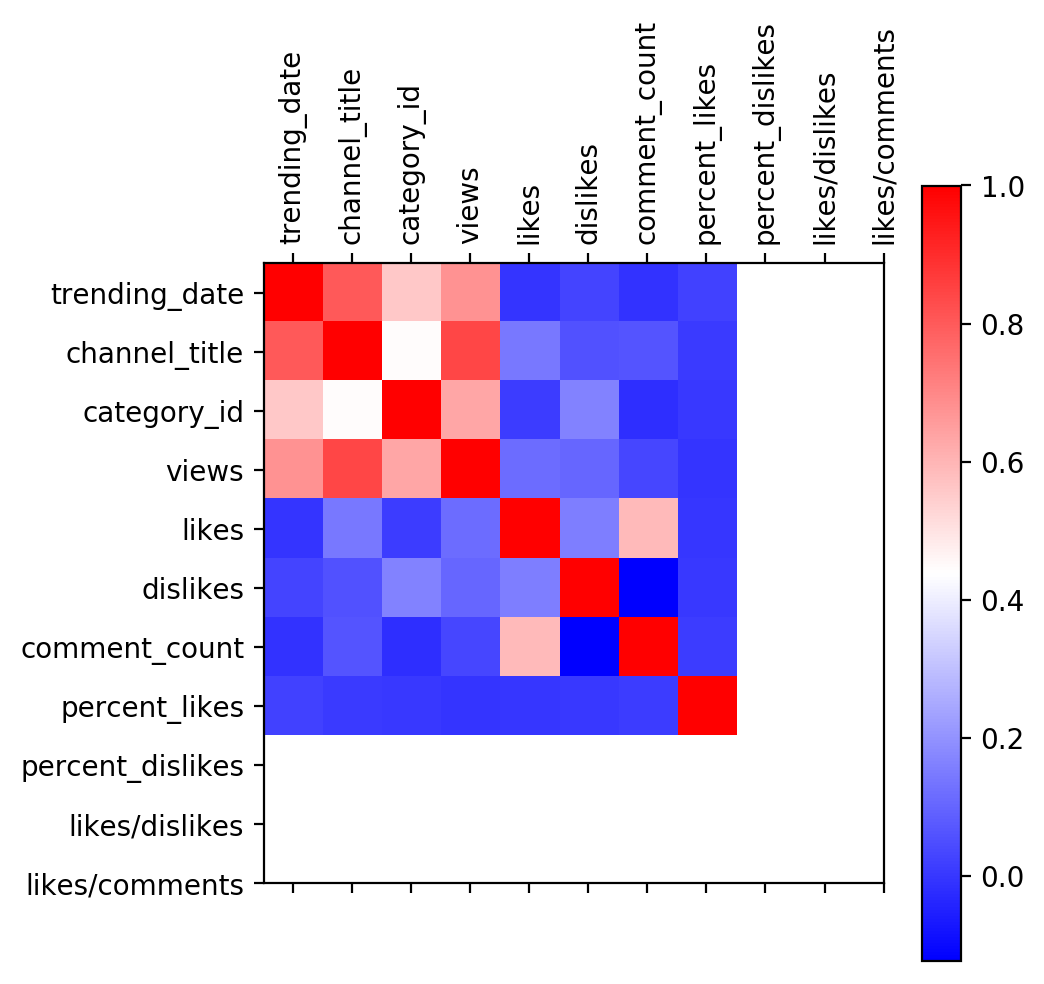

In [25]:
correlationData(dataMX)

In [26]:
print('\nPercent Likes Across Countries:\n',completeUSA['percent_likes'].mean())
print(completeGB['percent_likes'].mean())
print(completeCA['percent_likes'].mean())
print(completeMX['percent_likes'].mean())

print('\nPercent Dislikes Across Countries:\n',completeUSA['percent_dislikes'].mean())
print(completeGB['percent_dislikes'].mean())
print(completeCA['percent_dislikes'].mean())
print(completeMX['percent_dislikes'].mean())

print('\nPercent Percent Comments Across Countries:\n',completeUSA['percent_comments'].mean())
print(completeGB['percent_comments'].mean())
print(completeCA['percent_comments'].mean())
print(completeMX['percent_comments'].mean())

print('\nlikes/dislikes Across Countries:\n',completeUSA['likes/dislikes'].mean())
print(completeGB['likes/dislikes'].mean())
print(completeCA['likes/dislikes'].mean())
print(completeMX['likes/dislikes'].mean())

print('\nlikes/comments Across Countries:\n',completeUSA['likes/comments'].mean())
print(completeGB['likes/comments'].mean())
print(completeCA['likes/comments'].mean())
print(completeMX['likes/comments'].mean())

print('\Hour Published Across Countries:\n',completeUSA['hour_published'].median())
print(completeGB['hour_published'].median())
print(completeCA['hour_published'].median())
print(completeMX['hour_published'].median())

print('\Day Published Across Countries:\n',completeUSA['day_published'].mode())
print(completeGB['day_published'].mode())
print(completeCA['day_published'].mode())
print(completeMX['day_published'].mode())




print('\nViews Across Countries:\n',completeUSA['views'].mean())
print(completeGB['views'].mean())
print(completeCA['views'].mean())
print(completeMX['views'].mean())



Percent Likes Across Countries:
 3.4412976730882354
3.375992657391017
3.3411884734898107
4.787339228111621

Percent Dislikes Across Countries:
 0.16141535201730167
0.1621338936254915
0.13238090530755778
0.17567375573552044

Percent Percent Comments Across Countries:
 0.44530740279230996
0.42639132844290645
0.5630665362190942
0.7585152977606217

likes/dislikes Across Countries:
 4300.27836494529
8291.964322077694
4418.404695302308
3957.389318638724

likes/comments Across Countries:
 35557.012810828106
47061.81315778908
21535.360903879304
5449.434093210038
\Hour Published Across Countries:
 15.0
15.0
16.0
15.0
\Day Published Across Countries:
 0    Fri
dtype: object
0    Fri
dtype: object
0    Fri
dtype: object
0    Fri
dtype: object

Views Across Countries:
 2360784.6382573447
5911943.62663172
1147035.9107898534
342381.9681590072


In [27]:
print('\nCategory Prevalence in USA:\n',dataUSA.category_id.value_counts())
print('\nCategory Prevalence in GB:\n',dataGB.category_id.value_counts())
print('\nCategory Prevalence in CA:\n',dataCA.category_id.value_counts())
print('\nCategory Prevalence in MX:\n',dataMX.category_id.value_counts())



Category Prevalence in USA:
 Entertainment              9964
Music                      6472
Style                      4146
Comedy                     3457
Peaple and Blogs           3210
News and Politics          2487
Science and Tech.          2401
Film and Animation         2345
Sports                     2174
Education                  1656
Pets and Animals            920
Gaming                      817
Travel and Events           402
Vehicles                    384
Activism and Nonprofits      57
Shows                        57
Name: category_id, dtype: int64

Category Prevalence in GB:
 Music                      13754
Entertainment               9124
Peaple and Blogs            2926
Film and Animation          2577
Style                       1928
Sports                      1907
Comedy                      1828
Gaming                      1788
News and Politics           1225
Pets and Animals             534
Science and Tech.            518
Education                    457
V

In [59]:
#Finding percentage of individual videos in trending
dummy =completeMX['title'].nunique()
print(dummy)
print(completeMX.shape)
completeMX.head(n=100)

groupCA['days_trending'].mean()

33785
(40451, 138)


1.6636552313514834